In [1]:
%load_ext autoreload
%autoreload 2

import logging
import numpy as np
from scipy.stats import ortho_group
from matplotlib import pyplot as plt
import seaborn as sns
from munch import Munch
import torch
from torch.distributions import Normal, Independent
from torch.utils.data import DataLoader
from pyro.nn import DenseNN
from pyro.distributions.transforms import AffineCoupling

from vaemcmc.models.encoders import EncoderMLP
from vaemcmc.models.decoders import DecoderMLP
from vaemcmc.vae import NormalNormalVAE, VAETarget, f
from vaemcmc.mcmc import ISIRKernel
from vaemcmc.datasets.synthetic import SyntheticDataset
from vaemcmc.trainer import Trainer
from vaemcmc.viz.synthetic import plot_kde, plot_chain, scatter
from vaemcmc.models.rnvp import RNVP, FlowML

from vaemcmc.distributions.synthetic import Banana
from vaemcmc.distributions.transforms import GaussianEmbedding

/Users/evgeny/miniconda3/envs/vaemcmc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [110]:
args = Munch(
    amb_dim = 512,
    manifold_dim = 16,
    lat_dim = 32,
    hidden_dim = 128,
    n_blocks = 3,
    n_particles = 25,
    n_chains = 10,
    burn_in = 500,
    n_samples = 1000,
    n_epoch = 35,
    dummy_noise_scale = 0.5,
)


In [111]:
sigma_b = 5.0
banana_b = 0.02

xlim = (-15, 15)
ylim = (-4, 4)

PROJ = (args.manifold_dim - 2, args.manifold_dim - 1)

manifold_target = Banana(args.manifold_dim, banana_b, sigma_b)
# transform = torch.randn(args.amb_dim, args.amb_dim)
transform = torch.FloatTensor(ortho_group.rvs(dim=args.amb_dim))
target = GaussianEmbedding(manifold_target, args.amb_dim, transform, args.dummy_noise_scale, device)

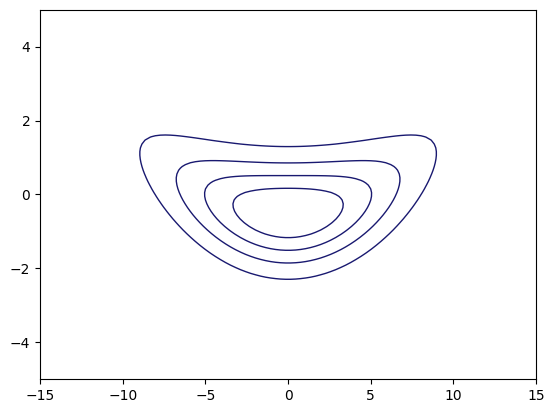

In [112]:
ax = plt.subplot()
target.plot_2d_contour(ax)
# ax.axis('auto')

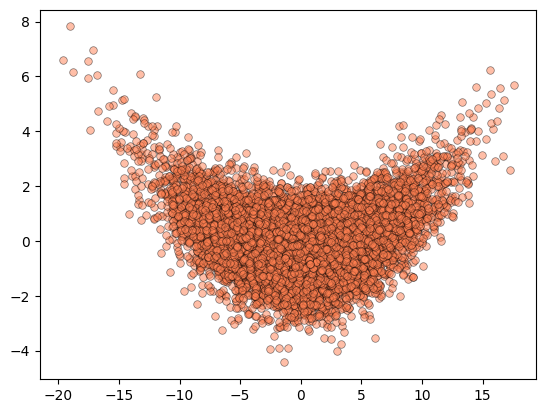

In [113]:
true_sample = target.sample((args.n_chains * args.n_samples,))
true_sample_proj = target.inv_embed(true_sample)
scatter(true_sample_proj[..., PROJ]);

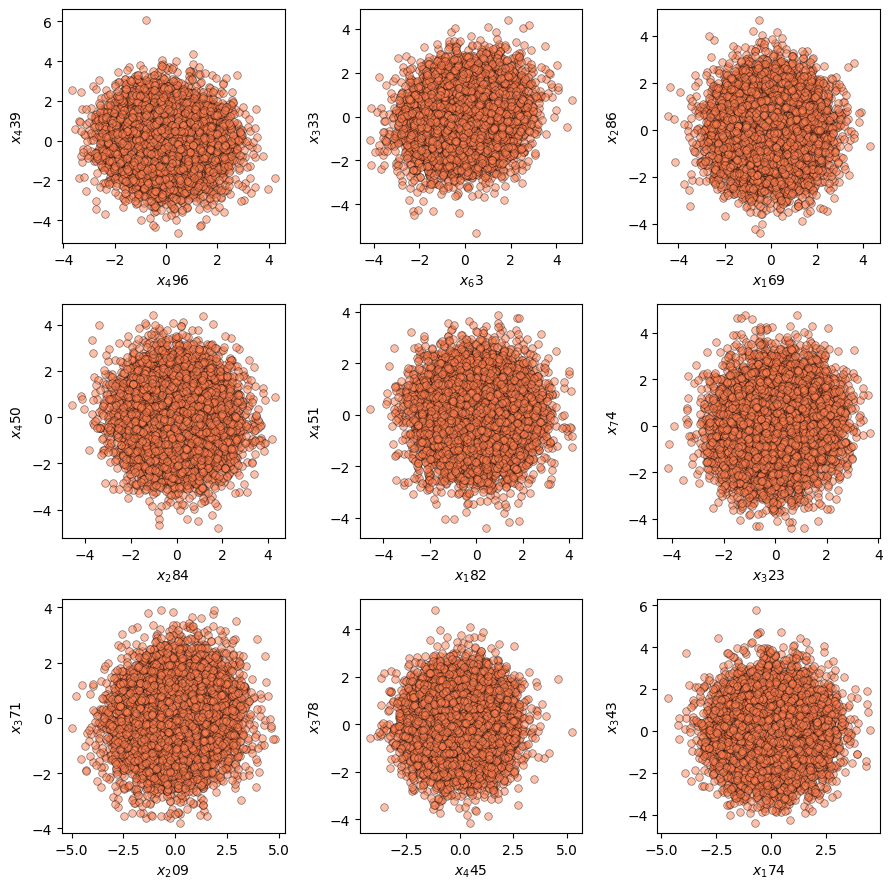

In [114]:
n_proj = 9
ids = np.arange(args.amb_dim)
np.random.shuffle(ids)
projs = ids[:18].reshape(-1, 2).tolist()
# projs[0] = PROJ

fig, axs = plt.subplots(3, 3, figsize=(9, 9))
for ax, proj in zip(axs.flatten(), projs):
    scatter(true_sample[..., proj], ax=ax);
    ax.set_xlabel(fr'$x_{proj[0]}$')
    ax.set_ylabel(fr'$x_{proj[1]}$')
    
fig.tight_layout()

In [115]:

# train_dataset = TensorDataset(target.sample(1000))
train_dataset = SyntheticDataset(target.sample((10000,)))
train_dataloader = DataLoader(train_dataset, batch_size=16)

val_dataset = SyntheticDataset(target.sample((10000,)))
val_dataloader = DataLoader(val_dataset, batch_size=16)

encoder = EncoderMLP(args.amb_dim, 2 * args.lat_dim, args.hidden_dim, n_layers=args.n_blocks)
decoder = DecoderMLP(args.lat_dim, 2 * args.amb_dim, args.hidden_dim, n_layers=args.n_blocks)

vae = NormalNormalVAE(encoder, decoder, fix_sigma=False)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

logging.basicConfig(format='%(asctime)s [%(levelname)-8s] %(message)s')
logger = logging.getLogger()
logger.setLevel(logging.INFO)
    
trainer = Trainer(vae, optimizer, train_dataloader, val_dataloader=val_dataloader, logger=logger)


In [116]:
trainer.train(args.n_epoch)

2023-06-01 13:47:03,381 [INFO    ] 4%|4         | 1/25 [00:02<00:59,  2.46s/it]
2023-06-01 13:47:04,939 [INFO    ] Loss: 748.1651611328125
2023-06-01 13:47:08,314 [INFO    ] 12%|#2        | 3/25 [00:07<00:54,  2.46s/it]
2023-06-01 13:47:08,790 [INFO    ] Loss: 746.7715454101562
2023-06-01 13:47:10,738 [INFO    ] 16%|#6        | 4/25 [00:09<00:51,  2.44s/it]
2023-06-01 13:47:12,787 [INFO    ] Loss: 751.9819946289062
2023-06-01 13:47:15,810 [INFO    ] 24%|##4       | 6/25 [00:14<00:47,  2.49s/it]
2023-06-01 13:47:16,790 [INFO    ] Loss: 747.1256103515625
2023-06-01 13:47:18,330 [INFO    ] 28%|##8       | 7/25 [00:17<00:45,  2.50s/it]
2023-06-01 13:47:21,051 [INFO    ] Loss: 743.0668334960938
2023-06-01 13:47:23,788 [INFO    ] 36%|###6      | 9/25 [00:22<00:41,  2.62s/it]
2023-06-01 13:47:25,135 [INFO    ] Loss: 738.0706787109375
2023-06-01 13:47:28,915 [INFO    ] 44%|####4     | 11/25 [00:27<00:36,  2.62s/it]
2023-06-01 13:47:29,426 [INFO    ] Loss: 742.9769897460938
2023-06-01 13:47:31,

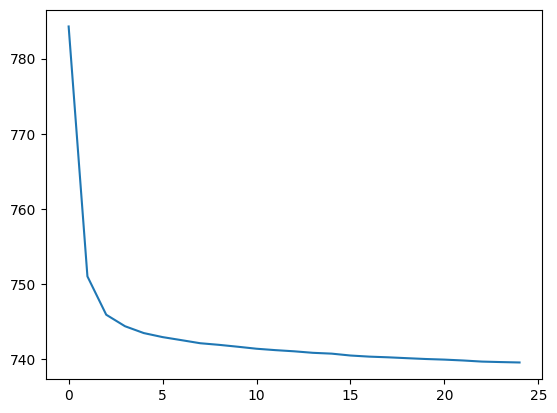

In [117]:
plt.plot(trainer.training_stats['epoch_loss'])

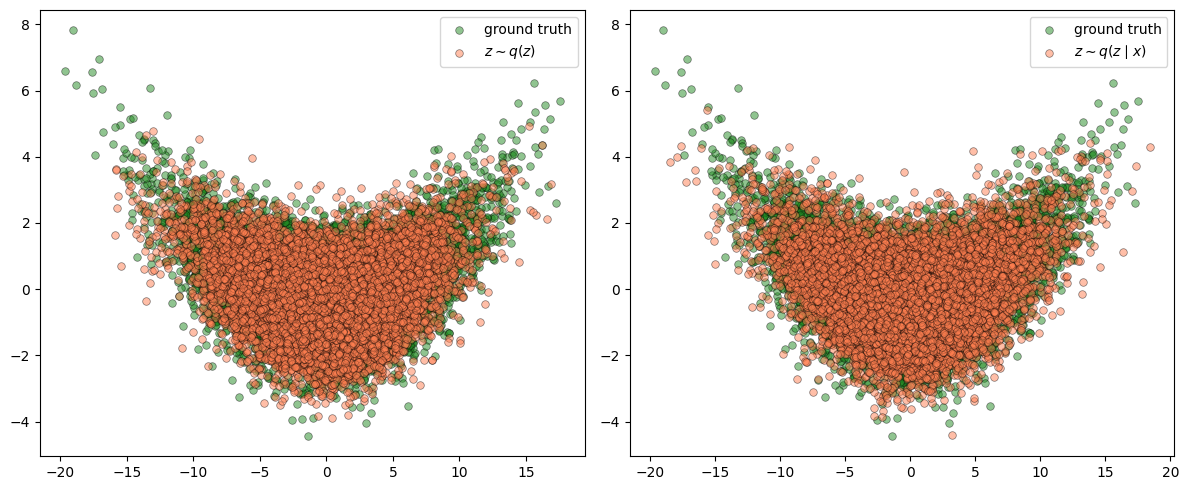

In [118]:
vae_sample = vae.sample((args.n_chains * args.n_samples,)).detach().cpu()
rec = vae(true_sample)[0].detach().cpu()

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs = axs.flatten()
for ax in axs:
    scatter(target.inv_embed(true_sample)[..., PROJ], c='forestgreen', ax=ax, label='ground truth')
    
scatter(target.inv_embed(vae_sample)[..., PROJ].view(-1, 2), ax=axs[0], label=r'$z \sim q(z)$')
scatter(target.inv_embed(rec)[..., PROJ].view(-1, 2), ax=axs[1], label=r'$z \sim q(z \mid x)$')

fig.tight_layout()
for ax in axs:
    ax.legend()


In [87]:
# proposal = Independent(Normal(torch.zeros(args.lat_dim), 2 * torch.ones(args.lat_dim)), 1)

# z_start = proposal.sample((args.n_chains,))

# target_vae = VAETarget(vae, target)
# isir_kernel = ISIRKernel(target_vae, proposal=proposal, n_particles=args.n_particles)

# vae_z_chain = isir_kernel.run(z_start, args.burn_in, args.n_samples)
# # x_start = vae.sample(z_start).detach().cpu()
# vae_x_chain = vae.cond_sample(vae_z_chain).detach().cpu()

In [121]:
prior = Independent(Normal(torch.zeros(args.lat_dim), 0.5 ** .5 * torch.ones(args.lat_dim)), 1)
proposal = VAEProposal(vae, prior)

x_start = true_sample[np.random.choice(np.arange(true_sample.shape[0]), args.n_chains)]
# x_start = proposal.sample((args.n_chains,))

isir_kernel = ISIRKernel(target, proposal=proposal, n_particles=args.n_particles)
vae_x_chain = isir_kernel.run(x_start, args.burn_in, args.n_samples)

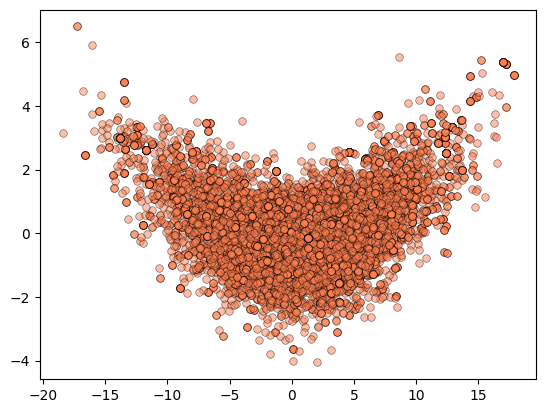

In [122]:
scatter(target.inv_embed(vae_x_chain)[..., PROJ].view(-1, 2));

(-4.0, 4.0)

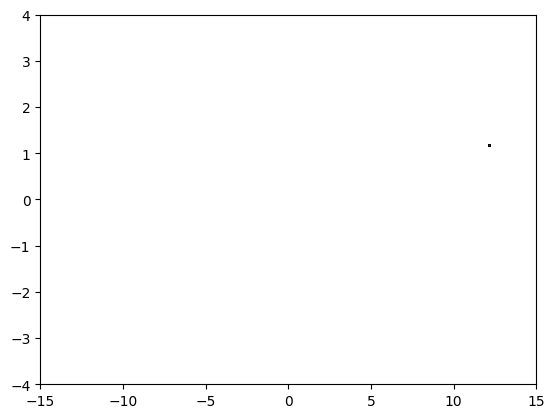

In [78]:
fig = plot_chain(target.inv_embed(vae_x_chain)[:, 0, PROJ])
ax = fig.get_axes()[0]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.set_aspect('equal')


In [20]:
split_dim = max(args.amb_dim - args.hidden_dim, args.amb_dim // 2)
flows = [
    AffineCoupling(
        split_dim,
        DenseNN(
            split_dim,
            [args.hidden_dim],
            [args.amb_dim - split_dim, args.amb_dim - split_dim],
        ),
    )
    for _ in range(args.n_blocks - 1)
]
split_dim = max(args.amb_dim - args.hidden_dim, args.amb_dim // 2)
flows.append(
    AffineCoupling(
        split_dim,
        DenseNN(
            split_dim,
            [args.hidden_dim],
            [args.amb_dim - split_dim, args.amb_dim - split_dim],
        ),
    )
)

rnvp = RNVP(flows=flows, dim=args.amb_dim)
rnvp_ml = FlowML(rnvp)
optimizer = torch.optim.Adam(rnvp_ml.parameters(), lr=3e-4)
trainer = Trainer(rnvp_ml, optimizer, train_dataloader, val_dataloader)

In [21]:
trainer.train(args.n_epoch)

2023-06-01 13:20:40,535 [INFO    ] 4%|4         | 1/25 [00:02<01:06,  2.78s/it]
2023-06-01 13:20:42,240 [INFO    ] Loss: 776.267333984375
2023-06-01 13:20:46,255 [INFO    ] 12%|#2        | 3/25 [00:08<01:02,  2.85s/it]
2023-06-01 13:20:46,805 [INFO    ] Loss: 784.1599731445312
2023-06-01 13:20:49,040 [INFO    ] 16%|#6        | 4/25 [00:11<00:59,  2.83s/it]
2023-06-01 13:20:51,269 [INFO    ] Loss: 777.3017578125
2023-06-01 13:20:55,216 [INFO    ] 24%|##4       | 6/25 [00:17<00:57,  3.01s/it]
2023-06-01 13:20:56,556 [INFO    ] Loss: 769.8333129882812
2023-06-01 13:20:58,603 [INFO    ] 28%|##8       | 7/25 [00:20<00:56,  3.13s/it]
2023-06-01 13:21:01,902 [INFO    ] Loss: 757.3524169921875
2023-06-01 13:21:05,140 [INFO    ] 36%|###6      | 9/25 [00:27<00:51,  3.20s/it]
2023-06-01 13:21:07,283 [INFO    ] Loss: 771.6338500976562
2023-06-01 13:21:11,541 [INFO    ] 44%|####4     | 11/25 [00:33<00:44,  3.18s/it]
2023-06-01 13:21:12,187 [INFO    ] Loss: 780.0619506835938
2023-06-01 13:21:14,967 

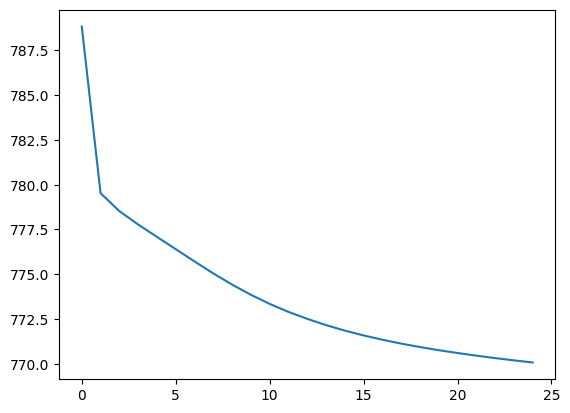

In [31]:
plt.plot(trainer.training_stats['epoch_loss'])

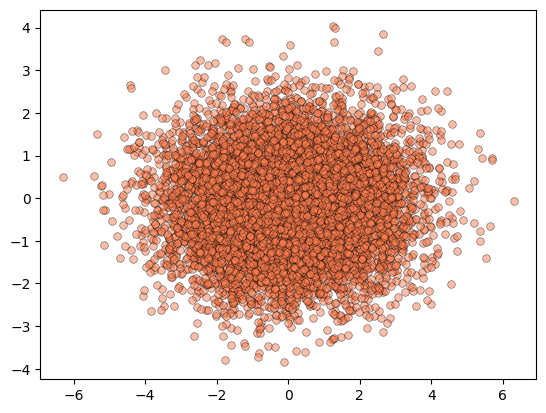

In [32]:
rnvp_sample = rnvp.sample((args.n_chains * args.n_samples,)).detach().cpu()

scatter(target.inv_embed(rnvp_sample)[:, PROJ]);

In [33]:
proposal = rnvp
isir_kernel = ISIRKernel(target, proposal=proposal, n_particles=args.n_particles)

In [34]:
z_start = rnvp.sample((args.n_chains,))
rnvp_x_chain = isir_kernel.run(z_start, args.burn_in, args.n_samples)

In [35]:
# x_start = flow.inverse(z_start)[0].detach().cpu()
# x_chain = flow.inverse(chain)[0].detach().cpu()
x_start = z_start.detach().cpu()
rnvp_x_chain = rnvp_x_chain.detach().cpu()

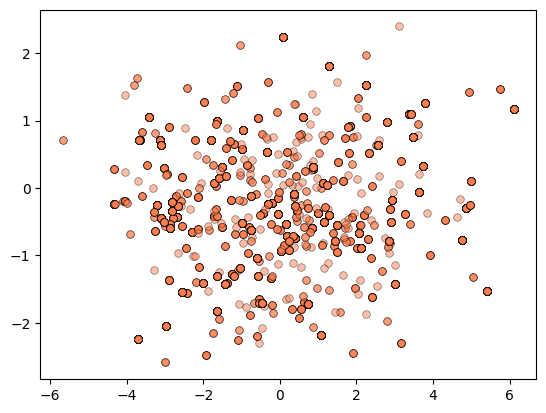

In [36]:
scatter(target.inv_embed(rnvp_x_chain)[..., PROJ].view(-1, 2));


In [37]:
# fig = plot_kde(rnvp_x_chain[..., PROJ], xlim, ylim)
# ax = fig.get_axes()[0]
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
# # ax.set_aspect('equal')


(-4.0, 4.0)

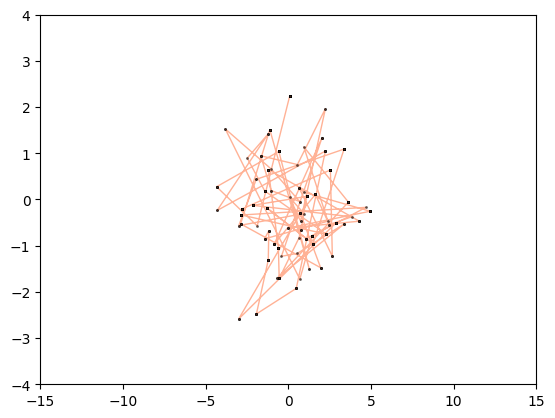

In [38]:
fig = plot_chain(target.inv_embed(rnvp_x_chain)[:, 0, PROJ])
ax = fig.get_axes()[0]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.set_aspect('equal')


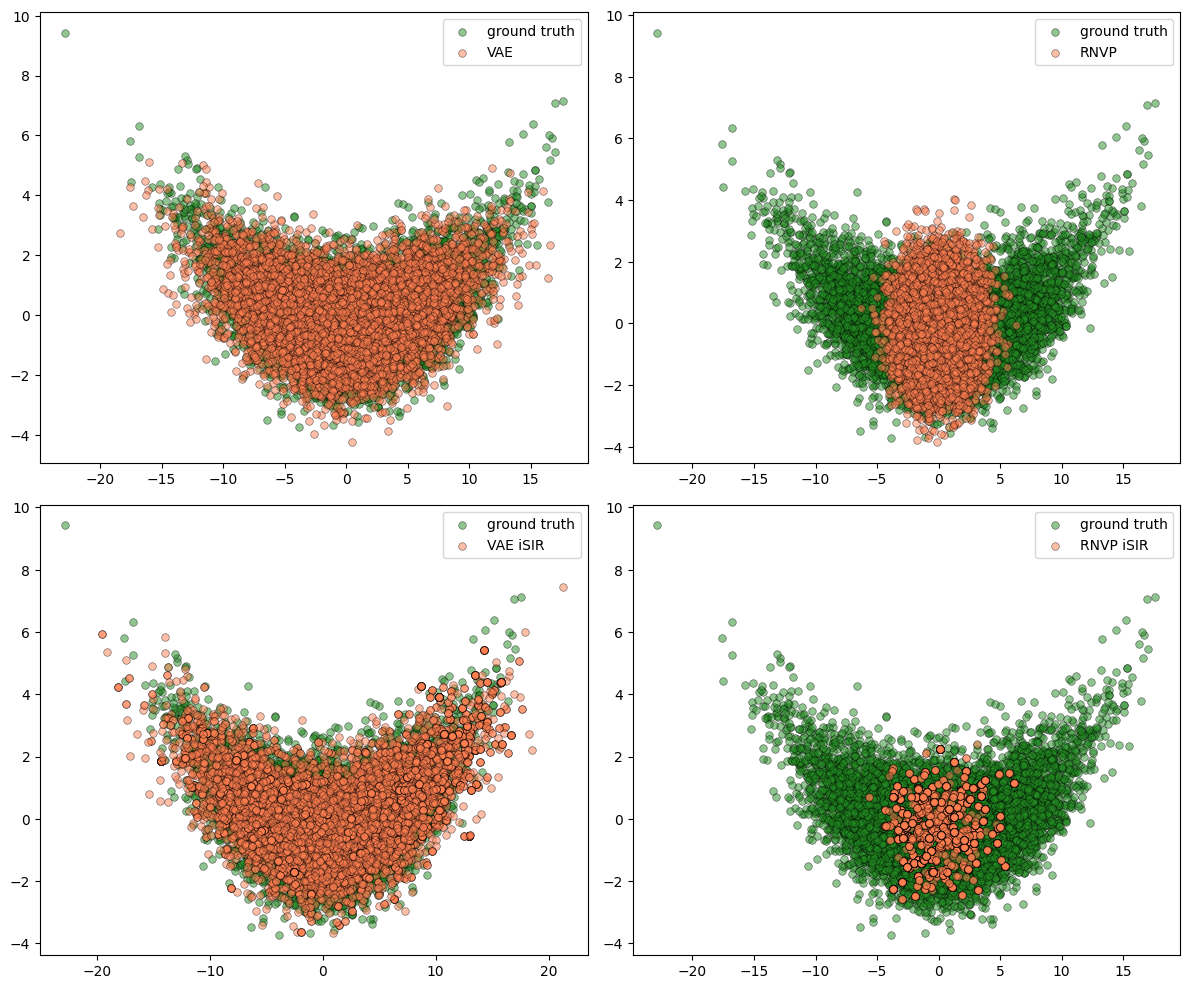

In [58]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs = axs.flatten()
for ax in axs:
    scatter(target.inv_embed(true_sample)[..., PROJ], c='forestgreen', ax=ax, label='ground truth')
    
scatter(target.inv_embed(vae_sample)[..., PROJ].view(-1, 2), ax=axs[0], label='VAE')
scatter(target.inv_embed(rnvp_sample)[..., PROJ].view(-1, 2), ax=axs[1], label='RNVP')

scatter(target.inv_embed(vae_x_chain)[..., PROJ].view(-1, 2), ax=axs[2], label='VAE iSIR')
scatter(target.inv_embed(rnvp_x_chain)[..., PROJ].view(-1, 2), ax=axs[3], label='RNVP iSIR')

fig.tight_layout()
for ax in axs:
    ax.legend()
plt.savefig('../figs/vae_rnvp_banana_embed.png')